<a href="https://colab.research.google.com/github/rubyvanrooyen/HartRAO_OH-IR_stars/blob/master/HartRAO_OH_periodogram_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone 'https://github.com/rubyvanrooyen/HartRAO_OH-IR_stars.git'
!ln -s HartRAO_OH-IR_stars/hart_io.py
!ln -s HartRAO_OH-IR_stars/periodogram.py

Cloning into 'HartRAO_OH-IR_stars'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 378 (delta 170), reused 345 (delta 151), pack-reused 0
Receiving objects: 100% (378/378), 10.00 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (170/170), done.


# Data input
Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

Input data file with selected blue and red channel data only as generated in `Detrending_HartRAO_OH_monitoring_data` notebook

In [1]:
# Importing files method from colab for accessing Local file system
from google.colab import files
uploaded = files.upload()

import io
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    bytes_io = io.BytesIO(uploaded[fn])
    byte_str = bytes_io.read()
    f = io.StringIO(byte_str.decode('UTF-8'))

Saving VMic_ts_blue4_red16_detrended.tscat to VMic_ts_blue4_red16_detrended.tscat
User uploaded file "VMic_ts_blue4_red16_detrended.tscat" with length 8290 bytes


In [2]:
#@title User input and parameters

#@markdown Name of source as in data file
source = "VMic" #@param ["Type here", "IKTau", "VMic"]  {allow-input: true}
#@markdown Julian date format for timestamp conversion
tsformat = 'mjd' #@param ["mjd", "jd"]
#@markdown Observation epoch for "jd" to "mjd" time conversion
epoch = 0. #@param {type:"number"}

print(f"Reading '{source}' OH monitoring file")
print(f"Assuming epoch {epoch} and "
      f"'{tsformat}' format for time interpretation")

Reading 'VMic' OH monitoring file
Assuming epoch 0.0 and 'mjd' format for time interpretation


In [3]:
# read input data assuming HartRAO format
import hart_io as io
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(file_obj=f,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [4]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')
[nts, nch] = spectra.shape

VMIC         OH1612 time series of intensities F from vmic.sf85
MJD, -4.072, 7.085

Spectral data size (#ts, #ch) = (157, 2)


# Periodogram calculation

In [5]:
import astropy.timeseries as stats
import math
import matplotlib.pylab as plt
import numpy as np
import os

from astropy.time import Time
from datetime import datetime, timedelta

In [6]:
blue_timeseries = spectra[:, 0]
blue_velocity = chan_vel[0]
red_timeseries = spectra[:, 1]
red_velocity = chan_vel[1]
jd_datetime = ts_jd.datetime

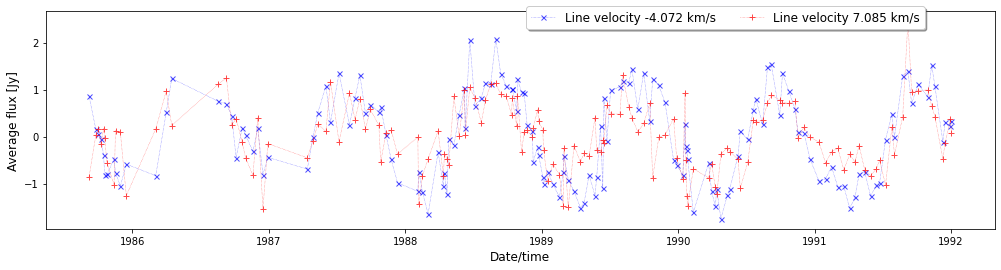

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.7)
ax.plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.7)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

## Compute the periodogram
Find the best period in days

In [8]:
import periodogram

#from periodogram import lomb_scargle
# we will upsample the signal for CSD calculations
dt = np.diff(ts_jd).min()

[blue_power,
 blue_frequency,
 blue_period,
 blue_time,
 blue_model] = periodogram.lomb_scargle(ts_jd.value,
                                        blue_timeseries,
                                        dt=dt.value)
blue_time = Time(np.array(blue_time), format=tsformat)

[red_power,
 red_frequency,
 red_period,
 red_time,
 red_model] = periodogram.lomb_scargle(ts_jd.value,
                                       red_timeseries,
                                       dt=dt.value)
red_time = Time(np.array(red_time), format=tsformat)

In [9]:
print(header)
period = (blue_period+red_period)/2.
print('Blue period = {:.2f} [days]'.format(blue_period))
print('Red period  = {:.2f} [days]'.format(red_period))
print('Avg period  = {:.2f} [days]'.format(period))

print('Deviation {:.3f} [days]'.format(np.abs(blue_period-red_period)/2.))

VMIC         OH1612 time series of intensities F from vmic.sf85
MJD, -4.072, 7.085

Blue period = 378.45 [days]
Red period  = 391.28 [days]
Avg period  = 384.86 [days]
Deviation 6.414 [days]


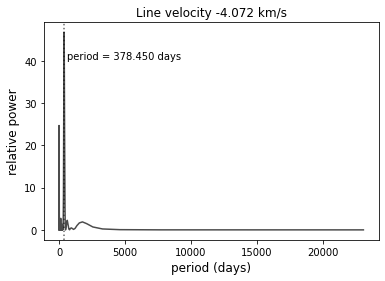

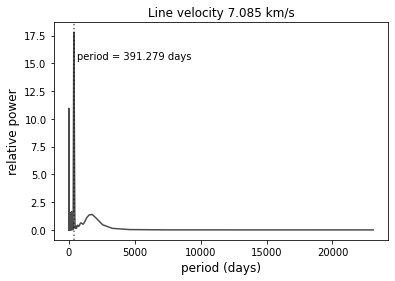

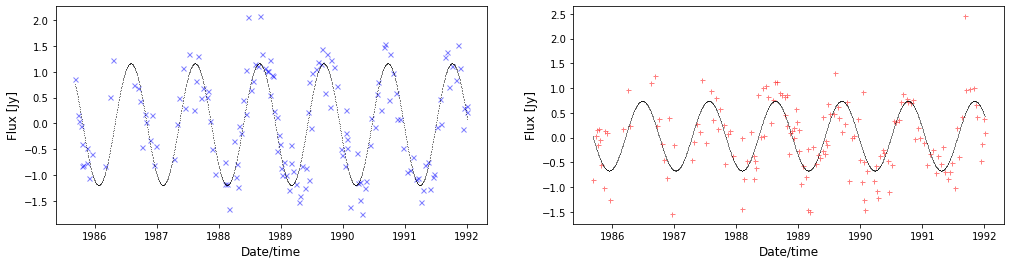

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(6, 4),
                       facecolor='white')
period_range = 1./blue_frequency  # period is the inverse of frequency
ax.plot(period_range, blue_power, 'k', alpha=0.7)
ax.axvline(blue_period, color='k',linestyle=':', alpha=0.6)
ax.set_title('Line velocity {} km/s'.format(blue_velocity))
ax.set_xlabel('period (days)', fontsize=12)
ax.set_ylabel('relative power', fontsize=12)
ax.text(0.07,0.83,
        'period = {:.3f} days'.format(blue_period),
        transform=ax.transAxes,
        color='k')
fig_name = f'{source}_blue_{blue_velocity:.3f}_periodogram.png'
plt.savefig(fig_name, bbox_inches='tight')

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(6, 4),
                       facecolor='white')
period_range = 1./red_frequency  # period is the inverse of frequency
ax.plot(period_range, red_power, 'k', alpha=0.7)
ax.axvline(red_period, color='k',linestyle=':', alpha=0.6)
ax.set_title('Line velocity {} km/s'.format(red_velocity))
ax.set_xlabel('period (days)', fontsize=12)
ax.set_ylabel('relative power', fontsize=12)
ax.text(0.07,0.83,
            'period = {:.3f} days'.format(red_period),
            transform=ax.transAxes,
            color='k')
fig_name = f'{source}_red_{red_velocity:.3f}_periodogram.png'
plt.savefig(fig_name, bbox_inches='tight')


fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
axs[0].plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[0].plot(blue_time.datetime, blue_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_ylabel('Flux [Jy]', fontsize=12)

axs[1].plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[1].plot(red_time.datetime, red_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_ylabel('Flux [Jy]', fontsize=12)

plt.show()

## Period calculation evaluation over smaller time steps

[Optional] A little bit of fine tuning the period calculation

In [11]:
# width defines bar width
# percent defines current percentage
def progress(niter, width, percent):
    marks = math.floor(width * (percent / 100.0))
    spaces = math.floor(width - marks)

    loader = '[' + ('=' * int(marks)) + (' ' * int(spaces)) + ']'

    msg = "%d %s %d%% iterations used" % (niter, loader, percent)
    print(f'\r {msg}', end="", flush=True)

    if percent >= 100:
        print("\n")

Given the assumption of the OH masers on the near and far side of a spherical dust sphere, we would expect the period of the channels to be close to each other, assuming they are equal distance separated from the central start and experiencing the same pumping mechanism.

In [37]:
def fine_tune_period(light_curve, smoothed_curve, setp=0.01):
    residual = light_curve - smoothed_curve
    rms = np.sqrt(np.mean(residual**2))
    est = (1. - rms)*period
    testp = np.arange(period-est, period+est, setp)
    phase_fit = np.linspace(0., 1., len(ts_jd.value))
    hndle = stats.LombScargle(timestamps, light_curve)
    rms = []
    print('enter here')
    for cnt, p in enumerate(testp):
        progress(cnt+1, 50, (float(cnt+1)/float(len(testp)))*100)
        f = 1./p
        mag_fit =hndle.model(t=ts_jd.value, frequency=f)
        residual = light_curve - mag_fit
        rms.append(np.sqrt(np.mean(residual**2)))
    # dummy print for progress
    print('exit here')
    return testp[np.argmin(rms)]

# fine tune period calculation

dt = np.diff(ts_jd).min()
fs = 1./dt  # Sample frequency 1/d
freq = 1./period  # Frequency in 1/d
timestamps = ts_jd.value
red_light_curve = red_timeseries - red_timeseries.mean()
red_model_opt = stats.LombScargle(timestamps, red_timeseries).model(t=timestamps, frequency=freq)
red_smoothed_curve = red_model_opt - red_model_opt.mean()
red_opt_period = fine_tune_period(red_light_curve, red_smoothed_curve)

import time
time.sleep(5)  # give buffer time to clear stuff

dt = np.diff(ts_jd).min()
fs = 1./dt  # Sample frequency 1/d
freq = 1./period  # Frequency in 1/d
timestamps = ts_jd.value
blue_light_curve = blue_timeseries - blue_timeseries.mean()
blue_model_opt = stats.LombScargle(timestamps, blue_timeseries).model(t=timestamps, frequency=freq)
blue_smoothed_curve = blue_model_opt - blue_model_opt.mean()
blue_opt_period = fine_tune_period(blue_light_curve, blue_smoothed_curve)

enter here
 39813 [==================================================] 100% iterations used

exit here
enter here
 41606 [================================================= ] 98% iterations used

In [15]:
print(f'Calculated red period {red_period:.3f} [days], '
      f'avg period {period:.3f} [days], '
      f'fine tuned period {red_opt_period:.3f} [days]')
err = np.abs(period-red_opt_period)
print(f'Uncertainty period pm {err:.3f} [days]')

print(f'Calculated red period {blue_period:.3f} [days], '
      f'avg period {period:.3f} [days], '
      f'fine tuned period {blue_opt_period:.3f} [days]')
err = np.abs(period-blue_opt_period)
print(f'Uncertainty period pm {err:.3f} [days]')

Calculated red period 391.279 [days], avg period 384.864 [days], fine tuned period 386.438 [days]
Uncertainty period pm 1.574 [days]
Calculated red period 378.450 [days], avg period 384.864 [days], fine tuned period 383.909 [days]
Uncertainty period pm 0.955 [days]


In [11]:
# get the models for the averaged period rather than the channel specific period
timestamps = ts_jd.value
diff = np.diff(ts_jd).min()

# relative phase shift between two signals from cross correlation
freq = 1./period  # Frequency in 1/d

model_time = periodogram.upsample(timestamps[0], timestamps[-1], diff.value)

blue_model = stats.LombScargle(timestamps, blue_timeseries).model(t=model_time, frequency=freq)
blue_channel = blue_model-blue_model.mean()
red_model = stats.LombScargle(timestamps, red_timeseries).model(t=model_time, frequency=freq)
red_channel = red_model-red_model.mean()

Model fit: $y(t; f, \bar{C}) = C_0 + \sum_n [C_{2n-1}\sin(2\pi nft) + C_{2n}\cos(2\pi nft)]$

In [12]:
ls_hndl = stats.LombScargle(timestamps, blue_timeseries)
coeffs = ls_hndl.model_parameters(freq)
print(f'Model parameters{coeffs.round(2)} @ freq {freq} 1/day')
_, power = ls_hndl.autopower()
false_alarm_prob = ls_hndl.false_alarm_probability(power.max())
if false_alarm_prob < 1e-5:
    print(f'False alarm probability << 1, high likelyhood of signal period relevance')
else:
    print(f'False alarm probability {false_alarm_prob*100.}%')

Model parameters[-0.01  0.96  0.69] @ freq 0.0025983197253286548 1/day
False alarm probability << 1, high likelyhood of signal period relevance


For periodogram calculations there is generally no direct relation to accuracy or error estimation.
What can be used as an estimate of relevance of the calculated period is to evaluate the significance of the peak via some form of false alarm probability.
This quantity is not an error indication, but rather a quantifies the probability of measuring this peak amplitude at this frequency, assuming Gaussian noise.
If this probability is $\ll 1\%$, it is a strong indication that this periodic signal is present.

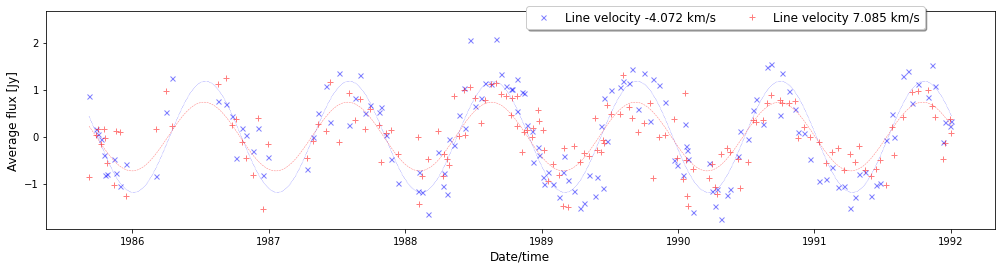

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='b', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='r', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

We see the period fit appropriately.
Since the mean amplitude is returned for the smooth function, changes in amplitude over the time series will not reflect in the smooth curve, as expected.

# Phase lag calculation
Relation between time delay ($\Delta T$) and phase lag ($\phi$): $2\pi \Delta T = \phi$

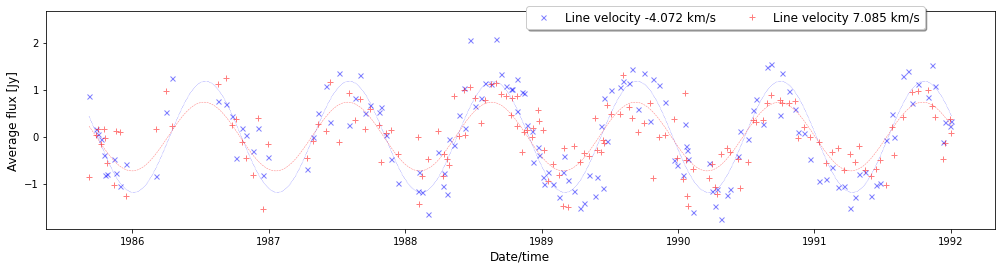

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='b', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='r', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

Fitting the calculated period provides upsampled smooth curves for the phase lag calculations.
Cross correlation is the standard method for estimating the degree of similarity between two signals.

The cross correlation $r$ at delay $d$ is defined as
$r = \frac{\sum_i [(x_i - mx)*(y_{i-d} - my)]}{\sqrt{\sum_i (x_i - mx)^2}\sqrt{\sum_i (y_{i-d}-my)^2}}$

The delay at which maximum correlation is achieved gives the phase difference between the blue and red time series.

In [15]:
phase_offset_rad=np.arccos(np.dot(blue_channel, red_channel)/(np.linalg.norm(blue_channel)*np.linalg.norm(red_channel)))
time_delay = phase_offset_rad/(2.*np.pi*freq)
print(f'phase offset {np.degrees(phase_offset_rad)} [deg] indicates time difference of {time_delay} [days]')

phase offset 3.930555565225611 [deg] indicates time difference of 4.202027101196508 [days]


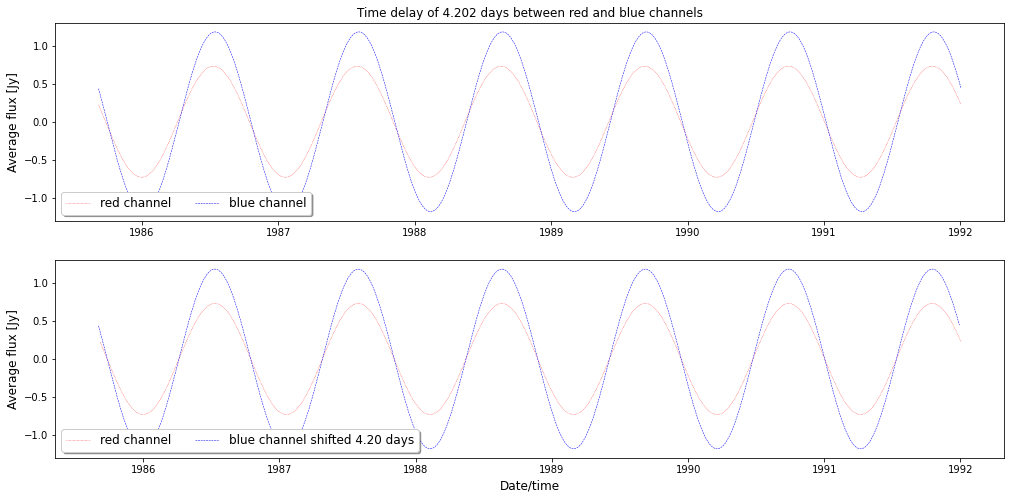

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(17, 8),
                        facecolor='white')
axs[0].plot(red_time.datetime, red_model-red_model.mean(),
            color='r', linestyle=':', linewidth=0.5,
            label='red channel')
axs[0].plot(blue_time.datetime, blue_model-blue_model.mean(),
            color='b', linestyle='--', linewidth=0.5,
            label='blue channel')
axs[0].set_title('Time delay of {:.3f} days between red and blue channels'.format(time_delay))
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

axs[1].plot(red_time.datetime, red_model-red_model.mean(),
            color='r', linestyle=':', linewidth=0.5,
            label='red channel')
if time_delay > 0:
    blue_shifted = blue_time.datetime-timedelta(days=time_delay)
else:
    blue_shifted = blue_time.datetime+timedelta(days=time_delay)
axs[1].plot(blue_shifted, blue_model-blue_model.mean(),
            color='b', linestyle='--', linewidth=0.5,
            label='blue channel shifted {:.2f} days'.format(time_delay))
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)
plt.show()

In [19]:
def get_folded_phase(ts, period):
    """Fold the observation times with the best period of the variable signal."""
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (ts / period) % 1
    return phase

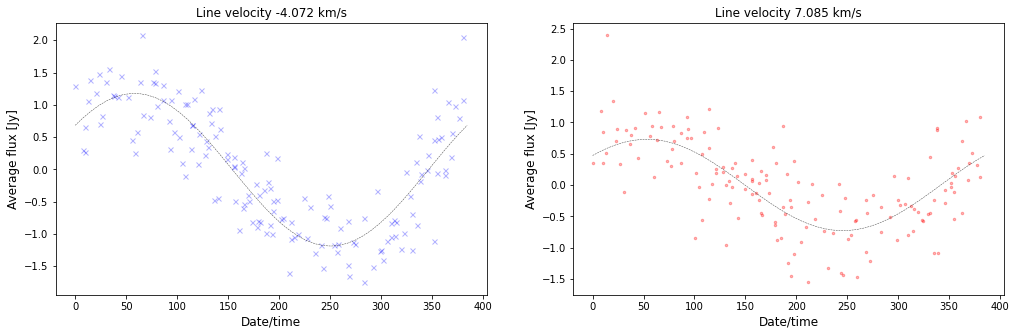

In [20]:
# compute model fitted values
phase_fit = np.linspace(0., 1.)
phase = get_folded_phase(ts_jd.value, period)

blue_mag_fit = stats.LombScargle(
                ts_jd.value, blue_timeseries - blue_timeseries.mean()).model(
                    t=phase_fit * period, frequency=1./period)

red_mag_fit = stats.LombScargle(
                ts_jd.value, red_timeseries - red_timeseries.mean()).model(
                    t=phase_fit * period, frequency=1./period)

# Plot folded lightcurve
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 5),
                        facecolor='white')
axs[0].plot(period*phase, blue_timeseries - blue_timeseries.mean(),
            color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[0].plot(period*phase_fit, blue_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))

axs[1].plot(period*phase, red_timeseries - red_timeseries.mean(),
            color='r', marker='.', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[1].plot(period*phase_fit, red_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))

filename = list(uploaded.keys())[0]
outfile = os.path.basename(filename)
[name, ext] = os.path.splitext(outfile)
fig_name = f'{name}_folded.png'
plt.savefig(fig_name, bbox_inches='tight')

plt.show()